In [1]:
import pandas as pds
import numpy as np
import os
import seaborn as sns
from matplotlib import pyplot as plt
import defs
import simu

In [2]:
name_DF = 'DF_N=4401_2023-01-16.csv'
DF = pds.read_csv(os.path.join('..', 'datasets', name_DF), delimiter = ',')
DF = DF[~DF.duplicated()] # delete duplicates
DF = DF.dropna() # delete NaN values
DF['was_assigned_female'] = DF['was_assigned_female'].astype('int32') # turn was_born_female into int type (once Nan values have been removed)
DF = DF.drop(['name', 'family_name'], axis=1)

# generate covariates
DF['X1'] = 2020 - DF['birth_year'] # age
DF['X2'] = np.random.normal(loc = 2.5, scale = 1, size = DF.shape[0])
DF['X3'] = np.random.normal(loc = 0, scale = 1, size = DF.shape[0])
DF['X4'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])
DF['X5'] = np.random.normal(loc = 1, scale = 1, size = DF.shape[0])

# generate treatment
DF['treatment'] = np.random.binomial(n = 1, p = 1 / ( 1 + np.exp(0.1*DF.X1 -0.2*DF.X2 +0.3*DF.X3 -0.4*DF.X4 +0.5*DF.X5) )) # probability depending on covariates

# generate outcome
residual_errors = np.random.normal(size = DF.shape[0])
aaa = 5.5
bbb = 0.01
ccc = 0.08
ddd = 0.7

ate_on_DF = aaa * 2.5
DF['Y'] = - 10 + aaa*DF['treatment']*DF['X2'] + bbb*np.exp(DF['X4']) + ccc*DF['X3']*DF['X1'] + ddd*DF['X5'] 

# generate new categorical variables for linkage
DF['id1'] = np.random.choice(np.arange(10), size = DF.shape[0]).astype(int)
DF['id2'] = np.random.choice(np.arange(15), size = DF.shape[0]).astype(int)
DF['id3'] = np.random.choice(np.arange(5), size = DF.shape[0]).astype(int)

identifiers = {'was_assigned_female':'strict','country':'strict','birth_year':'strict','id1':'strict','id2':'strict','id3':'strict'} # 'family_name':'jaro-winkler',
covariates = ['X1','X2','X3','X4','X5']

nbr_in_common = 100
nbr_iter = 2500
approx_integral = 50
a_sigma, b_sigma, a_sigma2, b_sigma2, a, b, alpha_pi, beta_pi = 1, 1, 1, 1, 1, 1, 1, 1
montecarlo_size_CI = 105

methods = {'jaro-winkler':defs.jaro_winkler_similarity, 'levenshtein':defs.levenshtein_similarity, 'strict':defs.strict_equality, 'large':defs.large_equality}

dict_params_legend = {
    "unmatch":identifiers.keys(), 
    "match":identifiers.keys(), 
    "sigma_square":[f"$\sigma^2$"], 
    "betas":[ r"$\beta_0$", r"$\beta_1$", r"$\beta_2$", r"$\beta_3$", r"$\beta_4$", r"$\beta_5$", r"$\beta_6$", r"$\beta_7$" ], 
    "sigma2_square":[r"$\sigma_2^2$"], 
    "mu2":[r"$\mu_2$"], 
    "atel":["atel"]}

dict_params_title = {
    "unmatch":"unmatch", 
    "match":"match", 
    "sigma_square":r"$\sigma^2$", 
    "betas":r"$\beta$",
    "sigma2_square":r"$\sigma_2^2$", 
    "mu2":r"$\mu_2$", 
    "atel":"atel"}

sizeA = 430
sizeB = 250
n_A = sizeA + nbr_in_common
n_B = sizeB + nbr_in_common

In [3]:
params = {'DF':DF, 
          'identifiers':identifiers,
          'aaa':aaa, 
          'methods':methods, 
          'covariates':covariates,
          'nbr_in_common':100,
          'nbr_iter':nbr_iter, 
          'approx_integral':approx_integral, 
          'a_sigma':1, 
          'b_sigma':1, 
          'a_sigma2':1, 
          'b_sigma2':1, 
          'a':1, 
          'b':1, 
          'alpha_pi':1, 
          'beta_pi':1, 
          'montecarlo_size_CI':montecarlo_size_CI,
          'coverage':False,
          'burn_in':True}

dict_params, v, k, true_linkage_z, mean, bounds_tuple, ate_common_records, ate_mean = simu.Simulation_Gibbs_Sampler(params)

100%|██████████| 2500/2500 [05:39<00:00,  7.36it/s]


time for 2500 iterations: 6min

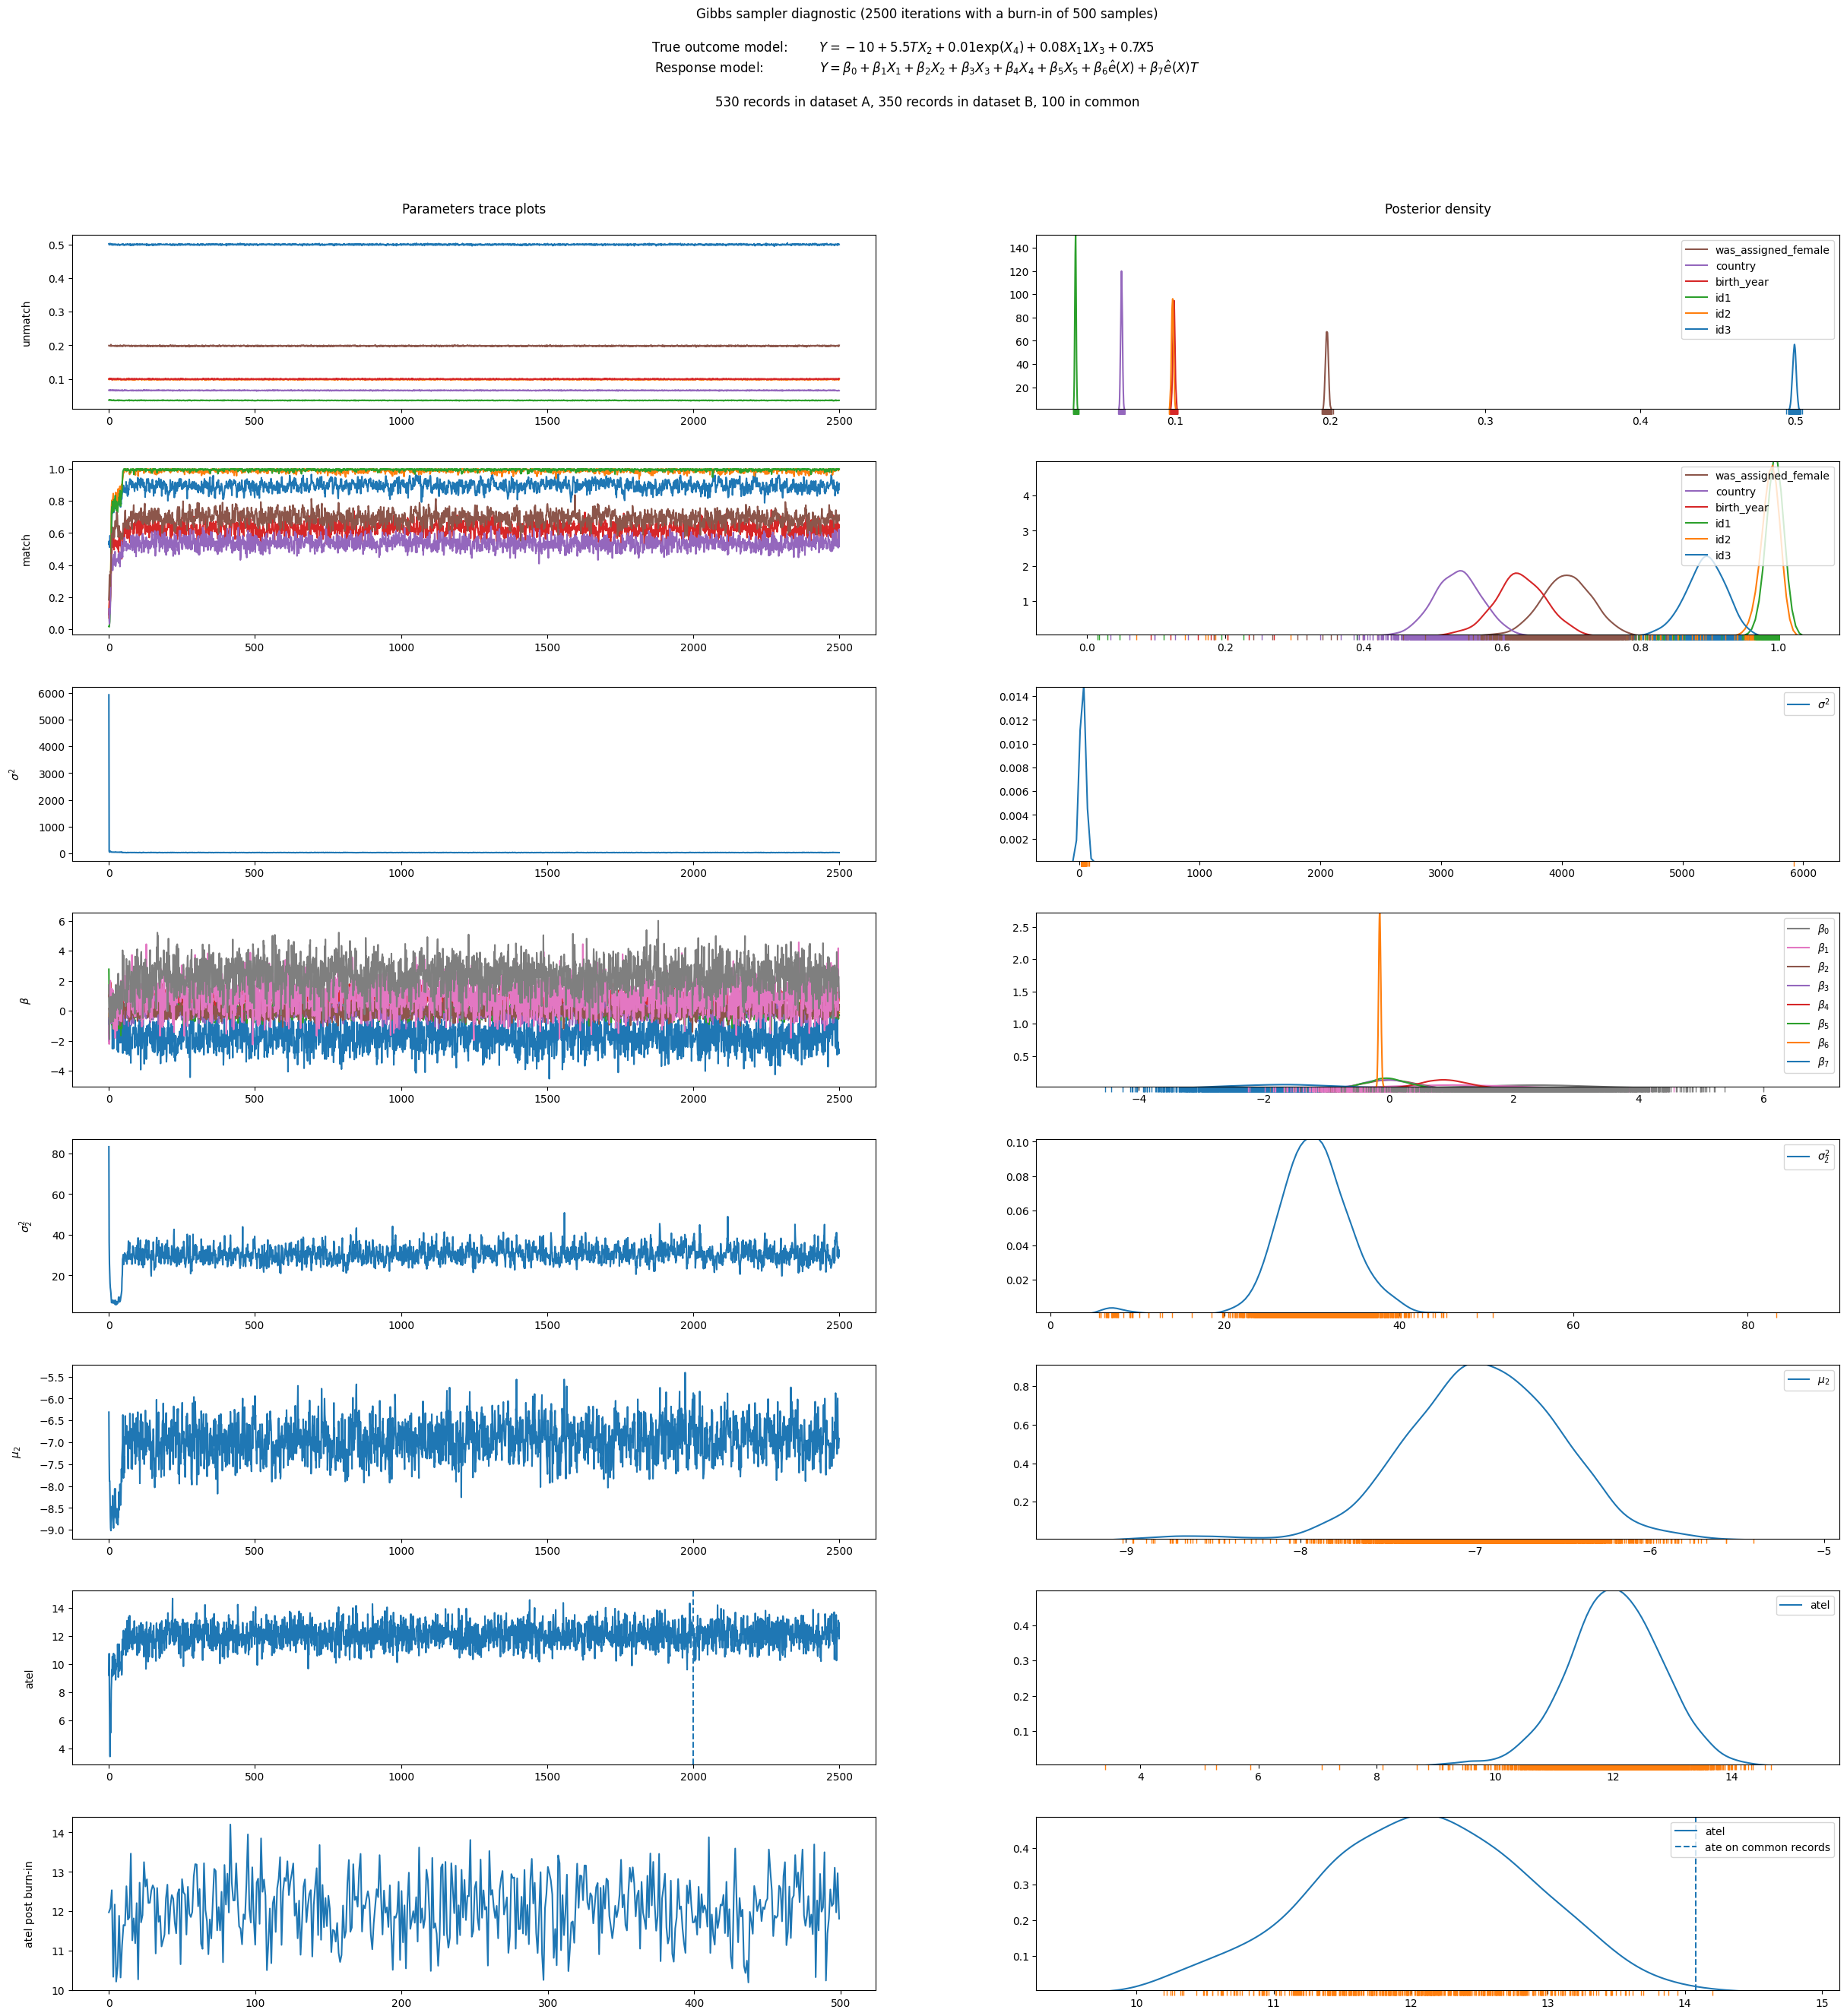

In [14]:
plt.figure(figsize = (30, 30))
plt.subplots_adjust(hspace=0.3)
plt.suptitle(f"Gibbs sampler diagnostic ({params['nbr_iter']} iterations with a burn-in of {int(params['nbr_iter']/5)} samples)\n\n"
             r"True outcome model:        $Y = -10 + 5.5 T X_2 + 0.01 \exp(X_4) + 0.08 X_11 X_3 + 0.7 X5$             ""\n"
             r"Response model:              $Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4 + \beta_5 X_5 + \beta_6 \hat e (X) + \beta_7 \hat e (X) T$""\n\n"
             f"{n_A} records in dataset A, {n_B} records in dataset B, {nbr_in_common} in common")
starting_point = 4*int(params['nbr_iter']/5)
i=0

for n, param in enumerate(dict_params.keys()):
    i+=1
    ax1 = plt.subplot(8, 2, n + i) # row, column, number on which current drawing
    ax1.plot(dict_params[param])
    if n==0:
        ax1.set_title("Parameters trace plots\n")
    ax1.set_xlabel("")
    ax1.set_ylabel(f"{dict_params_title[param]}\n")
    if param == "atel":
        ax1.axvline(starting_point, ls='--')
    j=i+1
    ax2 = plt.subplot(8, 2, n + j) 
    sns.kdeplot(data=np.array(dict_params[param]), ax=ax2, legend=None)
    sns.rugplot(data=np.array(dict_params[param]), ax=ax2, legend=None, height=-.03, clip_on=False)
    if n==0:
        ax2.set_title("Posterior density\n")
    ax2.legend(dict_params_legend[param], loc='upper right')
    ax2.set_xlabel("")
    ax2.set_ylabel("")

ax1 = plt.subplot(8, 2, 15)
ax1.plot(dict_params["atel"][starting_point:])
ax1.set_xlabel("")
ax1.set_ylabel(f"atel post burn-in\n")
ax2 = plt.subplot(8, 2, 16) 
sns.kdeplot(data=np.array(dict_params["atel"][starting_point:]), ax=ax2, label="atel")
sns.rugplot(data=np.array(dict_params["atel"][starting_point:]), ax=ax2, legend=None, height=-.03, clip_on=False)
ax2.axvline(ate_common_records, ls='--', label="ate on common records")
ax2.legend(loc='upper right')
ax2.set_xlabel("")
ax2.set_ylabel("")

plt.savefig(os.path.join('img', f"gibbs_sampler_diagnostic.pdf"), format="pdf", bbox_inches="tight")
plt.show()

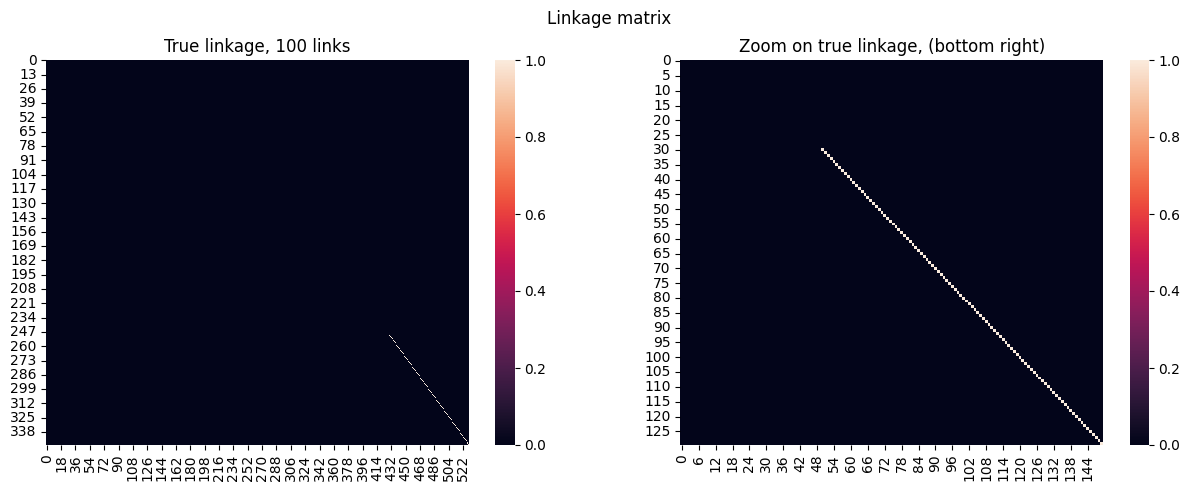

In [5]:
plt.figure(figsize = (15, 5))
plt.suptitle("Linkage matrix")
z_linkage_vector = true_linkage_z.copy()
idx_in_A_links = z_linkage_vector[z_linkage_vector>=0]
idx_in_B_links = np.nonzero(z_linkage_vector>=0)[0]
linkage_matrix = np.zeros((n_B, n_A))
for link in range(len(idx_in_A_links)):
    linkage_matrix[int(idx_in_B_links[link]), int(idx_in_A_links[link])] = 1
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(linkage_matrix, ax=ax1)
ax1.set_title(f"True linkage, {(linkage_matrix==1).sum()} links")
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(linkage_matrix[220:, 380:], ax=ax2)
ax2.set_title(f"Zoom on true linkage, (bottom right)")
plt.savefig(os.path.join('img', f"true_linkage_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

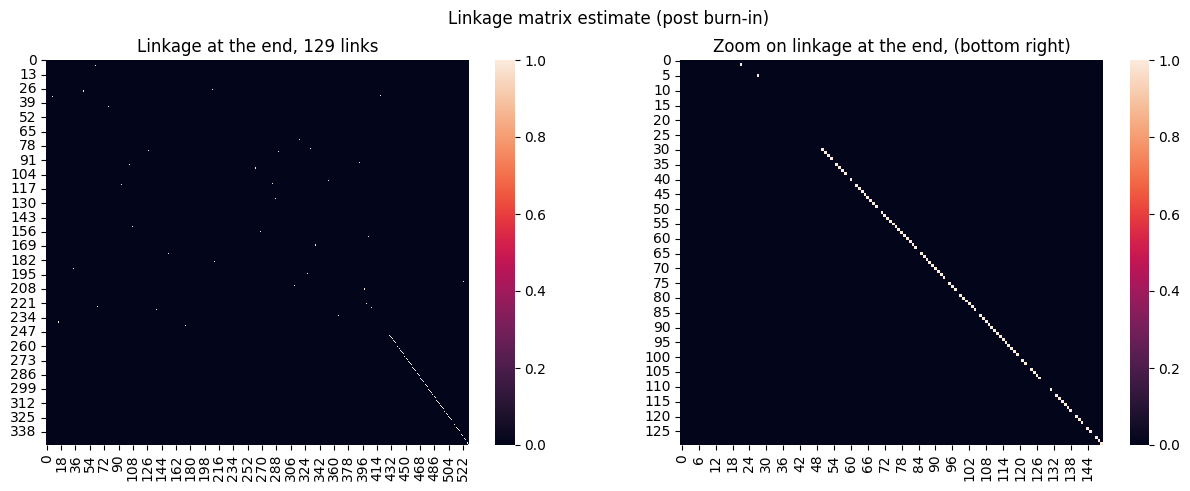

In [6]:
plt.figure(figsize = (15, 5))
plt.suptitle("Linkage matrix estimate (post burn-in)")
# maybe to do: add the burn in on this estiamte too!
# require to fix a number of link to make: k[np.argpartition(v, -100)[-100:]] # require to have high confidence enough for some links k[v>=0.9]
# very bad estimate if consider all iteration process
# estimate proportion of links with pi and a beta distr??
best = k[v>=0.8] 
idx_A = best[:,0]
idx_B = best[:,1]
linkage_matrix = np.zeros((n_B, n_A))
for link in range(len(idx_A)):
    A_idx = idx_A[link]
    B_idx = idx_B[link]
    linkage_matrix[B_idx, A_idx] = 1
ax1 = plt.subplot(1, 2, 1)
sns.heatmap(linkage_matrix, ax=ax1)
ax1.set_title(f"\nLinkage at the end, {(linkage_matrix==1).sum()} links")
ax2 = plt.subplot(1, 2, 2)
sns.heatmap(linkage_matrix[220:, 380:], ax=ax2)
ax2.set_title(f"\nZoom on linkage at the end, (bottom right)")
plt.savefig(os.path.join('img', f"linkage_at_end_{(linkage_matrix==1).sum()}links.pdf"), format="pdf", bbox_inches="tight")
plt.show()

In [7]:
nbr_simulations = 1

dict_coverage = {"mean":[], "bounds_tuple":[], "ate_common_records":[], "ate_mean":[]}

dict_coverage["mean"].append(mean)
dict_coverage["bounds_tuple"].append(bounds_tuple)
dict_coverage["ate_common_records"].append(ate_common_records)
dict_coverage["ate_mean"].append(ate_mean)

Text(0.5, 1.0, '95% credible interval for the ATE')

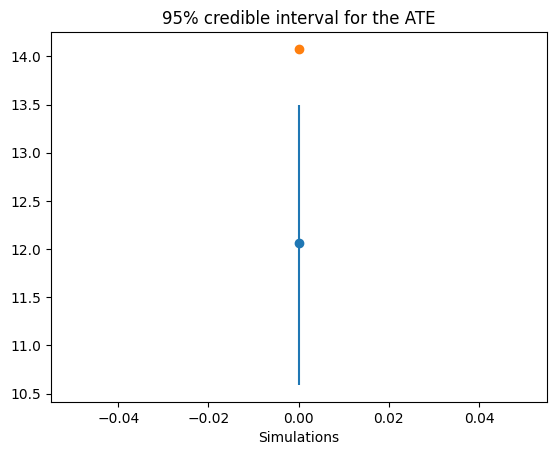

In [8]:
# computed with a burn in ! with a burn in!!

plt.errorbar(np.arange(nbr_simulations), dict_coverage["mean"], yerr=np.array(dict_coverage["bounds_tuple"]).T, fmt='o')
plt.plot(np.arange(nbr_simulations), dict_coverage["ate_common_records"], 'o')
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE")

Text(0.5, 1.0, '95% credible interval for the ATE centered around the ate_common_records')

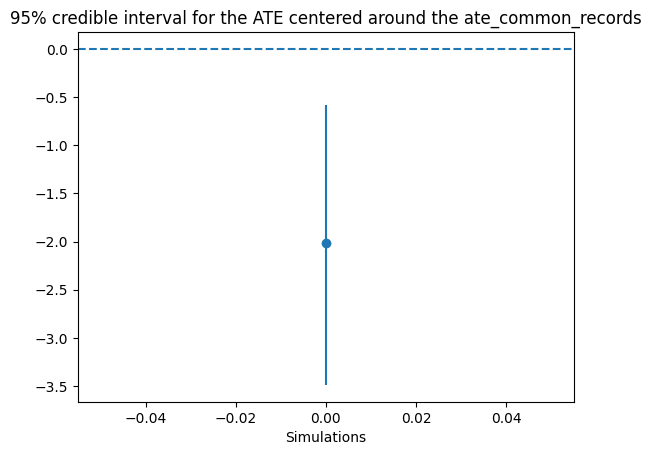

In [9]:
plt.errorbar(np.arange(nbr_simulations), dict_coverage["ate_mean"], yerr=np.array(dict_coverage["bounds_tuple"]).T, fmt='o')
plt.axhline(0, ls='--')
plt.xlabel("Simulations")
plt.title("95% credible interval for the ATE centered around the ate_common_records")